In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


## 전체 공통 함수

### 1. 데이터 보간 함수

- 데이터의 시간 간격을 0.5초의 등간격으로 맞추고 그에 따른 좌표 값을 보간함
- 가장 많이 사용되는 3차 스플라인 보간 적용

In [94]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

# 데이터 보간 - 위도, 고도, 경도 값을 0.5초 시간 간격으로 보간
def spline_interpolation(x, y):
    # x: 보간할 데이터의 x 값 (시간)
    # y: 보간할 데이터의 y 값 (위도, 고도, 경도)

    # 3차 스플라인 보간 함수 생성
    f = interp1d(x, y, kind='cubic')

    # 시간 범위 설정
    start_time = min(x)
    end_time = max(x)

    # 0.5초 간격의 시간 배열을 생성
    new_x = np.arange(start_time, end_time, 0.5)

    # 위도, 경도, 고도 보간
    new_y = f(new_x)

    return new_x, new_y

### 2. 시퀀스 나누는 함수

- 학습을 위해 데이터를 시퀀스 형태로 나눔
- look back과 forward에 따라 학습에 사용될 x값의 구간과 y값을 반환함
- 초기 look back은 10, forward는 0이다.

In [95]:
# 시퀀스 생성 함수
# look back : 10 (5초간의 위도, 고도, 경도 데이터를 x값으로 사용)
# forward : 0 (0.5초 뒤의 위도, 고도, 경도 데이터를 y값으로 사용)
def create_sequences(df, look_back=10, forward=0):
    xs = []
    ys = []
    for i in range(len(df) - look_back - forward):
        x = df.iloc[i:(i+look_back)].values
        y = df.iloc[i+look_back+forward].values
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

### 3. 시간 소수점 절사 함수

- 불필요한 시간 소수점 제거

In [96]:
import math

# 시간 소수점 절사 함수
def truncation(df):
    new_time = []

    for a in df['time']:
      new_time.append(math.floor(a * 10) / 10)

    df['time'] = new_time

    return df

### 4. 스케일링 함수

- MinMaxScaling 적용 함수


In [97]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaling 적용 함수
def min_max_scaling(df):

    # time 삭제 df 생성
    mid_df=df.drop(columns='time')

    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(mid_df)

    min_max_data = min_max_scaler.transform(mid_df)

    new_data = pd.DataFrame(min_max_data)

    # time 추가
    new_data.insert(0, 'time', df['time'])

    # 나머지 열의 이름 가져오기
    column_names = mid_df.columns.tolist()

    column_names.insert(0, 'time')

    print(column_names)

    # 새로운 데이터프레임에 열 이름 설정
    new_data.columns = column_names

    return min_max_scaler, new_data

### 5. train/validation/test 분리 함수

- Train, Validation, Test 데이터셋을 분리하는 함수이다.
- 각각의 비율은 6:2:2 이다.

In [98]:
from sklearn.model_selection import train_test_split

# train/validation/test 분리 함수
def split_train_val_test(X, y):

    #Train, Test 분류
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Train, Validation 분류
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


    # 데이터 크기 출력
    print("Train set:", X_train.shape, y_train.shape)
    print("Validation set:", X_val.shape, y_val.shape)
    print("Test set:", X_test.shape, y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

### 6. 경로 시각화 함수

- 실제 경로와 예측 경로를 각각 그래프로 생성

In [99]:
import matplotlib.pyplot as plt

# 경로 시각화 함수
def prediction_visualization(y_test, y_pred):
    # 시각화를 위해 위도, 경도, 고도 분리
    y_test_lat = y_test[:, 0]
    y_test_lon = y_test[:, 1]
    y_test_alt = y_test[:, 2]

    y_pred_lat = y_pred[:, 0]
    y_pred_lon = y_pred[:, 1]
    y_pred_alt = y_pred[:, 2]

    # 3D 그래프 생성
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 실제 값 플롯
    ax.scatter(y_test_lat, y_test_lon, y_test_alt, c='b', marker='o', label='Actual')

    # 예측 값 플롯
    ax.scatter(y_pred_lat, y_pred_lon, y_pred_alt, c='r', marker='^', label='Predicted')

    # 그래프 제목 및 축 레이블 설정
    ax.set_title('Actual vs Predicted')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Altitude')

    # 범례
    ax.legend()

    # 그래프를 화면에 출력
    plt.show()

### 성능 테스트 함수

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluation(y_test, y_pred):

    # MSE (Mean Squared Error) 계산
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # MAE (Mean Absolute Error) 계산
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")

    # 예측 결과와 실제 값을 비교하는 샘플 출력
    for i in range(5):  # 예시로 첫 5개만 출력
        print(f"Actual: {y_test[i]}, Predicted: {y_pred[i]}")

## 전처리

### 1. 데이터셋 가져오기

In [101]:
import pandas as pd

# 데이터셋 가져오기 (필요시 저장 경로 수정)
raw = pd.read_csv("/content/drive/MyDrive/deep-uav/OnboardGPS.csv")

### 2. 데이터셋 전처리

- 데이터셋 보간
- 소수점 절사
- MinMaxScaling 적용


In [102]:
df = raw[['Timpstemp', ' lat', ' lon', ' alt']]

new_x, lat = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lat'])
new_x, lon = spline_interpolation(df['Timpstemp'] / 1e6 , df[' lon'])
new_x, alt = spline_interpolation(df['Timpstemp'] / 1e6 , df[' alt'])

df = pd.DataFrame({"time":new_x, "lat":lat, "lon":lon, "alt":alt})

df = truncation(df)
scaler, df = min_max_scaling(df)

['time', 'lat', 'lon', 'alt']


## 모델 선언

### 1. 모델 클래스 선언
- GRU를 사용한 모델 클래스 선언
- 구조 : GRU + Fully Connected Layer

In [119]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# 하이퍼파라미터와 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_units, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_units, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력만 사용
        return out

In [122]:
# Optuna의 목적 함수 정의
def objective(trial, df, batch_size, sequence_length):
    # 하이퍼파라미터 탐색 범위
    n_layers = trial.suggest_int('n_layers', 1, 3)
    n_units_l0 = trial.suggest_int('n_units_l0', 32, 128)
    # dropout = trial.suggest_float('dropout', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    # batch_size = trial.suggest_int('batch_size', 16, 64)

    # 메인 코드
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, val_loader, test_loader = prepare_dataloader(df, batch_size, sequence_length)

    # 첫 번째 배치를 가져와 input_size, output_size 계산
    first_batch = next(iter(train_loader))
    X_train_batch, y_train_batch = first_batch
    input_size = X_train_batch.shape[2]  # 입력 데이터의 feature 크기
    output_size = y_train_batch.shape[1]  # 예측할 값의 크기

    # 모델 및 데이터 설정
    model = GRUModel(input_size, n_units_l0, output_size, n_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 모델 학습
    for epoch in range(10):  # 10 epochs
        train_model(model, criterion, optimizer, train_loader, device)

    ## 검증 손실 계산
    val_loss, _, _ = evaluate_model(model, criterion, val_loader, device)
    return val_loss

In [105]:
# 모델 학습 함수
def train_model(model, criterion, optimizer, loader, device):
    model.train()
    total_loss = 0
    for batch_x, batch_y in loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

In [106]:
# 검증 및 테스트 함수
def evaluate_model(model, criterion, loader, device):
    model.eval()
    total_loss = 0
    true_values = []
    predictions = []

    start_time = time.time()  # 예측 시작 시간 기록

    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            loss = criterion(output, batch_y)
            total_loss += loss.item()
            true_values.append(batch_y.cpu().numpy())
            predictions.append(output.cpu().numpy())

    end_time = time.time()  # 예측 종료 시간 기록
    total_inference_time = end_time - start_time

    print(f"Total Inference Time: {total_inference_time:.2f} seconds")

    return total_loss / len(loader), true_values, predictions

## 학습

### 1. 데이터 준비

1. 시퀀스 생성
2. Train, Validation, Test 분리
3. DataLoader에 load

In [107]:
# 데이터셋 및 DataLoader 준비
def prepare_dataloader(df, batch_size, sequence_length):
    train_x, train_y = create_sequences(df[['lat', 'lon', 'alt']], sequence_length)

    X_train, X_val, X_test, y_train, y_val, y_test = split_train_val_test(train_x, train_y)

    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    val_dataset = TensorDataset(torch.Tensor(X_val), torch.Tensor(y_val))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [108]:
batch_size = 32
sequence_length = 10

### 2. 최적의 하이퍼파라미터 탐색

#### 1. 하이퍼 파라미터 탐색

In [123]:
import optuna

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, df, batch_size, sequence_length), n_trials=1)

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)

[I 2024-09-27 06:34:15,162] A new study created in memory with name: no-name-895dc79b-9757-4bab-b23a-b36c60662c1b
<ipython-input-122-1bf29e0bb5dc>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Train set: (3250, 10, 3) (3250, 3)
Validation set: (1084, 10, 3) (1084, 3)
Test set: (1084, 10, 3) (1084, 3)


[I 2024-09-27 06:34:26,736] Trial 0 finished with value: 0.0011554228703436606 and parameters: {'n_layers': 2, 'n_units_l0': 43, 'learning_rate': 0.000179719553047678}. Best is trial 0 with value: 0.0011554228703436606.


Total Inference Time: 0.12 seconds
Best hyperparameters:  {'n_layers': 2, 'n_units_l0': 43, 'learning_rate': 0.000179719553047678}


#### 2. 하이퍼파라미터 저장

In [115]:
import json

### 하이퍼 파라미터 저장

# 최적의 하이퍼파라미터를 JSON 파일로 저장
with open("best_hyperparameters.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best hyperparameters have been saved to 'best_hyperparameters.json'")

Best hyperparameters have been saved to 'best_hyperparameters.json'


#### 3. 하이퍼파라미터 불러오기

In [116]:
import json

# 1. 저장된 하이퍼파라미터 불러오기
with open("best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded best hyperparameters:", best_params)

Loaded best hyperparameters: {'n_layers': 2, 'n_units_l0': 65, 'dropout': 0.3177086972523787, 'learning_rate': 0.001177923154362332, 'batch_size': 20}


### 3. 최적의 파라미터로 모델 학습

In [124]:
# 최적의 모델 학습
best_params = study.best_params

train_loader, val_loader, test_loader = prepare_dataloader(df, batch_size, sequence_length)

best_model = GRUModel(input_size=3, hidden_units=best_params['n_units_l0'], output_size=3, num_layers=best_params['n_layers'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

Train set: (3250, 10, 3) (3250, 3)
Validation set: (1084, 10, 3) (1084, 3)
Test set: (1084, 10, 3) (1084, 3)


In [125]:
import time
import torch

best_model.train()
total_train_time = 0  # 총 학습 시간 기록 변수

num_epochs = 1
for epoch in range(num_epochs):  # 최종 모델 학습
    best_model.train()
    train_loss = 0.0
    epoch_start_time = time.time()  # 에포크 시작 시간 기록
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        print(batch_x.shape)

        output = best_model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    epoch_end_time = time.time()  # 에포크 종료 시간 기록
    epoch_duration = epoch_end_time - epoch_start_time  # 한 에포크의 학습 시간
    total_train_time += epoch_duration  # 총 학습 시간에 추가

    # Validation set에서 성능 측정
    best_model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)  # 입력 데이터 차원 조정
            batch_y = batch_y.to(device)
            output = best_model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # 모델 저장
    model_save_path = f"best_model_epoch_{epoch+1}.pth"
    torch.save(best_model.state_dict(), model_save_path)
    print(f"Model saved: {model_save_path}")

    print(f"Epoch {epoch+1}/{50} completed in {epoch_duration:.2f} seconds.")

print(f"Total training time: {total_train_time:.2f} seconds.")


torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 10, 3])
torch.Size([32, 

In [126]:
!pip install torchinfo

In [127]:
from torchinfo import summary

summary(best_model, (1, 10, 3), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 3]                    --
├─GRU: 1-1                               [1, 10, 43]               17,544
├─Linear: 1-2                            [1, 3]                    132
Total params: 17,676
Trainable params: 17,676
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07

## 테스트

### 1. 테스트 결과 생성

In [128]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# 모델 예측 및 성능 평가
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loss = 0
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # 예측 수행
        output = best_model(batch_x)

        # 손실 계산
        loss = criterion(output, batch_y)
        test_loss += loss.item()

        # 예측값과 실제값 저장
        y_pred_list.append(output.cpu().numpy())  # 예측값을 CPU로 이동하여 numpy 배열로 변환
        y_true_list.append(batch_y.cpu().numpy())  # 실제값을 CPU로 이동하여 numpy 배열로 변환

# 리스트를 numpy 배열로 변환
y_pred = np.concatenate(y_pred_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# 성능 평가
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 0.0058509185910224915
Mean Absolute Error (MAE): 0.059199634939432144


### 2. 결과 시각화

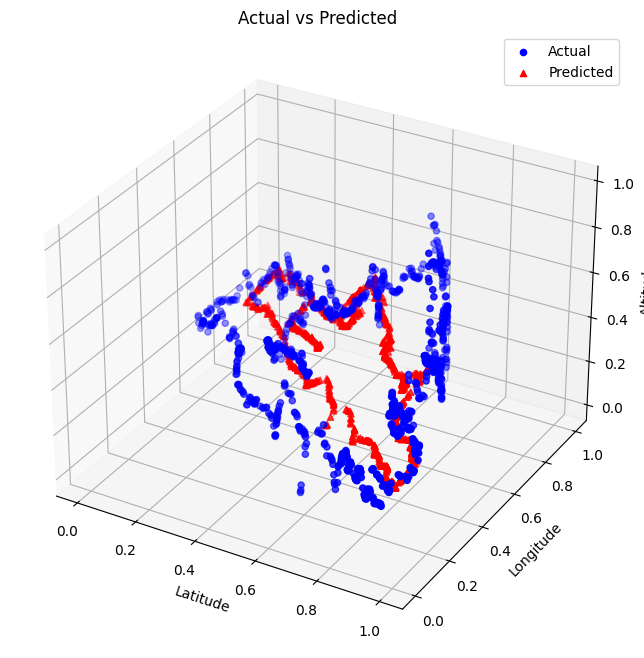

In [129]:
prediction_visualization(y_true, y_pred)

Todo
- min max scaling 풀어서, raw랑 찍어보기
- epoch이랑 batch, learning rate 찍어보기
- 파라미터 수 측정
- 모델 구조 출려 코드

#### 3. raw 데이터와 predict 데이터 비교

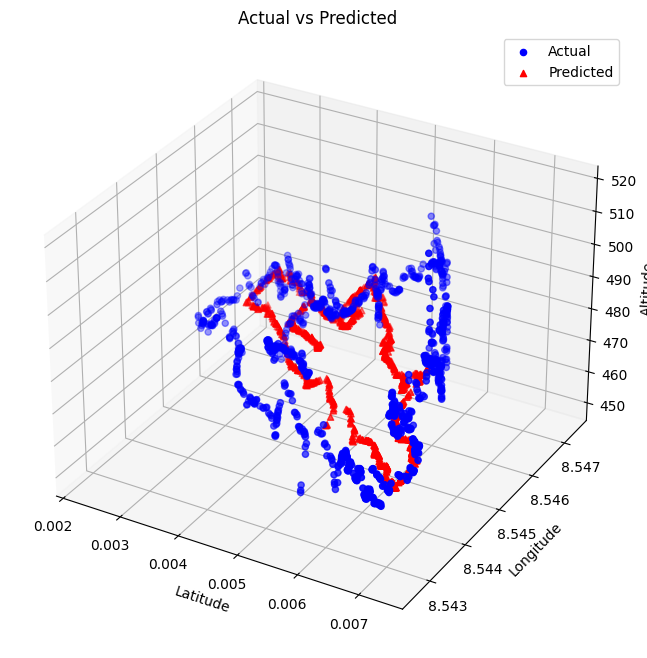

In [130]:
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = scaler.inverse_transform(y_true.reshape(-1, 3))

prediction_visualization(y_test_original, y_pred_original)

# 기타

In [20]:
# # 최적의 하이퍼파라미터로 모델 학습 및 평가
# def train_and_evaluate(best_params, num_epochs=50):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     train_loader, val_loader, test_loader = prepare_dataloader(X_train, X_val, X_test, y_train, y_val, y_test, best_params['batch_size'])

#     # 첫 번째 배치로 input/output 크기 결정
#     first_batch = next(iter(train_loader))
#     input_size = first_batch[0].shape[2]
#     output_size = first_batch[1].shape[1]

#     # 모델 초기화
#     model = GRUModel(input_size, best_params['n_units_l0'], output_size, best_params['n_layers'], best_params['dropout']).to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

#     # 학습 및 검증 기록
#     history = {'train_loss': [], 'val_loss': []}

#     start_time = time.time() # 학습 시작 시간 기록

#     for epoch in range(num_epochs):
#         train_loss = train_model(model, criterion, optimizer, train_loader, device)
#         val_loss, _, _ = evaluate_model(model, criterion, val_loader, device)
#         history['train_loss'].append(train_loss)
#         history['val_loss'].append(val_loss)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

#     end_time = time.time()
#     total_training_time = end_time - start_time

#     print(f"Total Training Time: {total_training_time:.2f} seconds")

#     return model, history

In [22]:
# import matplotlib.pyplot as plt

# def plot_loss(history):
#     # 학습 중 기록된 train_loss와 val_loss 그래프 그리기
#     epochs = len(history['train_loss'])  # 기록된 에포크 수
#     plt.plot(range(epochs), history['train_loss'], label='Train Loss')
#     plt.plot(range(epochs), history['val_loss'], label='Validation Loss')
#     plt.title('Train and Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

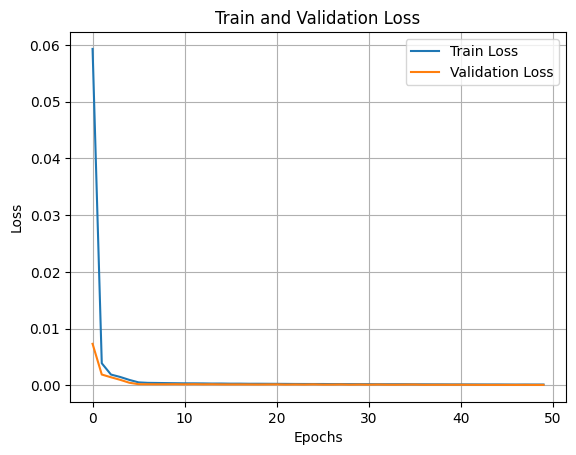

In [23]:
plot_loss(history)

Total Inference Time: 0.37 seconds
Test Loss: 0.0001


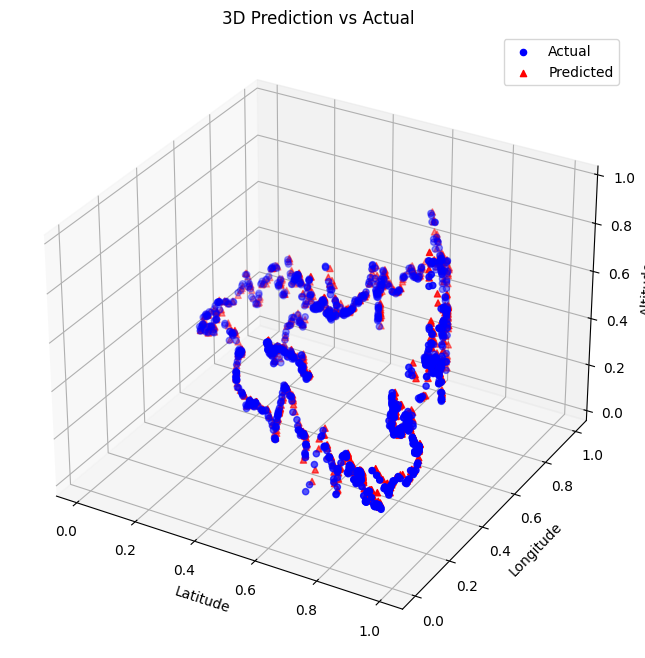

In [24]:
# # 테스트 데이터 평가
# train_loader, val_loader, test_loader = prepare_dataloader(X_train, X_val, X_test, y_train, y_val, y_test, best_params['batch_size'])

# test_loss, true_values, predictions = evaluate_model(model, nn.MSELoss(), test_loader, 'cpu')
# print(f"Test Loss: {test_loss:.4f}")

# prediction_visualization(true_values, predictions)

In [35]:
# !pip install torchinfo

# from torchinfo import summary

# summary(model, (1, 10, 3), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 3]                    --
├─GRU: 1-1                               [1, 10, 109]              109,218
├─Linear: 1-2                            [1, 3]                    330
Total params: 109,548
Trainable params: 109,548
Non-trainable params: 0
Total mult-adds (M): 1.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.44
Estimated Total Size (MB): 0.45

In [37]:
X_test.shape, y_test.shape

((1082, 10, 3), (1082, 3))

In [70]:
# import numpy as np
# from sklearn.preprocessing import MinMaxScaler

# # 예시로 X_test와 y_test가 이렇게 생겼다고 가정
# X_test = np.random.rand(1082, 10, 3)
# y_test = np.random.rand(1082, 3)

# # min_max_scaler가 이미 학습되어 있다고 가정합니다.
# # 예시: min_max_scaler.fit(train_data)

# # X_test와 y_test를 원래 스케일로 되돌리기 위한 함수
# def inverse_min_max_scaling_X_y(X_test, y_test, scaler):
#     # 3D 데이터를 2D로 변경 (샘플 수 * 시퀀스 길이, feature)
#     X_test_2D = X_test.reshape(-1, X_test.shape[2])

#     # X_test 역변환 (스케일러는 feature 단위로 동작)
#     X_test_original = scaler.inverse_transform(X_test_2D)

#     # 다시 3D로 reshape (원래 형태로 복구)
#     X_test_original = X_test_original.reshape(X_test.shape)

#     # y_test는 2D이므로 바로 역변환
#     y_test_original = scaler.inverse_transform(y_test)

#     return X_test_original, y_test_original

# # 원래 스케일로 변환
# X_test_original, y_test_original = inverse_min_max_scaling_X_y(X_test, y_test, min_max_scaler)

# # 결과 확인
# print("Original X_test shape:", X_test_original.shape)
# print("Original y_test shape:", y_test_original.shape)


Original X_test shape: (1082, 10, 3)
Original y_test shape: (1082, 3)
